In [1]:
import numpy as np
import pandas as pd

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
#from modAL.models import Committee
#from modAL.disagreement import vote_entropy_sampling

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

import recordlinkage as rl
from active_learn import*

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from importlib import reload
#reload(spam)

In [2]:
df_uns = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\df_uns_label_img_1.csv')
df_full = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\merged_clean_df.csv')
df_full.drop('Unnamed: 0',axis=1,inplace=True)

#Manually annotated data
test_1 = rl.read_annotation_file(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\result_bnb_trip.json')
test_2 = rl.read_annotation_file(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\result_bnb_vrb.json')

#Baselines fully labeled
#df_base_train = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\UnsupervisedBootAL-master\datasets\wdc_product\features_phones_phones_catalog_train')
#df_base_test = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\UnsupervisedBootAL-master\datasets\wdc_product\features_phones_phones_catalog_test')
#Baseline with unsupervised
df_full_base = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\df_uns_label_base_train.csv')
df_full_base['label'] = df_full_base['label'].map(to_bin)

In [3]:
df_base_train = df_full_base.loc[:1761]
df_base_test = df_full_base.loc[1762:]

In [4]:
compare(df_full,10161202, 10161074,full=False)

https://www.airbnb.nl/rooms/10161202
https://www.airbnb.nl/rooms/10161074


'Links retreived'

In [5]:
#Take out the labeled data for making a test set 
manual_labeled = []

#Getting the Listing Ids bc the files is in index 
for x,y in test_1.links:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),1])
    manual_labeled.append([str(tuple_2),1])
    
for x,y in test_2.links:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),1])
    manual_labeled.append([str(tuple_2),1])
for x,y in test_1.distinct:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),0])
    manual_labeled.append([str(tuple_2),0])
    
for x,y in test_2.distinct:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),0])
    manual_labeled.append([str(tuple_2),0])

 #Merging to have it with the full data   
df_labeled = pd.DataFrame(manual_labeled,columns=['ids','labels'])
df_labeled
with_labels =df_uns.merge(df_labeled,on='ids',how='left')


In [6]:
df_labeled

,ids,labels
0,"(11252596, 21319730)",1
1,"(21319730, 11252596)",1
2,"(14548324, 18113908)",1
3,"(18113908, 14548324)",1
4,"(14548324, 18285070)",1
...,...,...
465,"(10917883, 43763917)",0
466,"(21198240, 7662177)",0
467,"(7662177, 21198240)",0
468,"(9530785, 1037906)",0


In [7]:
#Baseline models data
not_train = ['source_id','target_id','ids', 'agg_score', 'weights','uns_label','label']
X_train = df_base_train.drop(not_train, axis=1).values
y_train = df_base_train['label'].values
X_test = df_base_test.drop(not_train, axis=1).values
y_test = df_base_test['label'].values

In [8]:
#Decision Tress serach for hyperparameters
params = {'max_leaf_nodes': list(range(2, 100)),'max_depth' : [None, 3, 5, 10, 15], 
        'min_samples_leaf' : [3, 5, 10], 'criterion' : ['gini', 'entropy']}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)
#Best parameters
print(grid_search_cv.best_params_)
#Get the perd metrics of the model 
y_pred = grid_search_cv.predict(X_test)
precision_recall_fscore=precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)
print('Precision:',precision_recall_fscore[0],
      'Recall:',precision_recall_fscore[1],
      'Fscore:',precision_recall_fscore[2])

Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 8820 out of 8820 | elapsed:  2.5min finished


{'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': 7, 'min_samples_leaf': 3}
Precision: 0.7884615384615384 Recall: 0.803921568627451 Fscore: 0.7961165048543688


In [9]:
# Logistic Reg search for hyperparameters
params = {'penalty' :['l1', 'l2'],'fit_intercept' : [True, False],
        'solver' :['liblinear', 'saga'],'max_iter' : [50, 100, 150]}

grid_search_cv = GridSearchCV(LogisticRegression(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)
#Best parameters
print(grid_search_cv.best_params_)
#Get the perd metrics of the model 
y_pred = grid_search_cv.predict(X_test)
precision_recall_fscore=precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)
print('Precision:',precision_recall_fscore[0],
      'Recall:',precision_recall_fscore[1],
      'Fscore:',precision_recall_fscore[2])

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   29.7s finished


{'fit_intercept': True, 'max_iter': 150, 'penalty': 'l1', 'solver': 'saga'}
Precision: 0.7959183673469388 Recall: 0.7647058823529411 Fscore: 0.7799999999999999


In [193]:
# SVM search for hyperparameters
params = {'kernel':['linear', 'rbf'], 'gamma':[0.1, 1, 5, 10] ,'C' : [0.5, 1, 5, 10]}

grid_search_cv = GridSearchCV(SVC(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)
#Best parameters
print(grid_search_cv.best_params_)
#Get the perd metrics of the model 
y_pred = grid_search_cv.predict(X_test)
precision_recall_fscore=precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)
print('Precision:',precision_recall_fscore[0],
      'Recall:',precision_recall_fscore[1],
      'Fscore:',precision_recall_fscore[2])


Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
Precision: 0.7884615384615384 Recall: 0.803921568627451 Fscore: 0.7961165048543688


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   26.7s finished


In [195]:
# XGBoost search for hyperparameters
params = {'n_estimators':[100, 150, 200],'learning_rate':[0.05, 0.1, 0.15],'max_depth':[3, 5, 7]}


grid_search_cv = GridSearchCV(xgb.XGBClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)
#Best parameters
print(grid_search_cv.best_params_)
#Get the perd metrics of the model 
y_pred = grid_search_cv.predict(X_test)
precision_recall_fscore=precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)
print('Precision:',precision_recall_fscore[0],
      'Recall:',precision_recall_fscore[1],
      'Fscore:',precision_recall_fscore[2])


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  1.2min finished


{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}
Precision: 0.8461538461538461 Recall: 0.8627450980392157 Fscore: 0.854368932038835


In [196]:
# Random Forest search for hyperparameters
params = {'n_estimators':[10, 50, 100] ,'max_depth':[None, 3, 5, 10, 15],'min_samples_leaf':[3, 5, 10]}

grid_search_cv = GridSearchCV(RandomForestClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)
#Best parameters
print(grid_search_cv.best_params_)
#Get the perd metrics of the model 
y_pred = grid_search_cv.predict(X_test)
precision_recall_fscore=precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)
print('Precision:',precision_recall_fscore[0],
      'Recall:',precision_recall_fscore[1],
      'Fscore:',precision_recall_fscore[2])

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Precision: 0.8297872340425532 Recall: 0.7647058823529411 Fscore: 0.7959183673469387


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   26.5s finished


In [8]:
#Comitee of models
def randomforest_com():
    clf = RandomForestClassifier()#n_estimators=10,min_samples_split=2,warm_start=False,max_depth=5
    return clf

def desiciontree():
    clf= DecisionTreeClassifier()#criterion ='gini', max_depth= None,max_leaf_nodes= 7,min_samples_leaf= 3
    return clf
def logisticreg():
    clf = LogisticRegression()#fit_intercept= True,max_iter=150, penalty= 'l1',solver= 'saga'
    return clf
def xbg_class():
    clf = xgb.XGBClassifier() #learning_rate=0.1,max_depth= 7,n_estimators = 150
    return clf
def svm():
    clf = SVC(probability=True)#,C= 1,gamma= 0.1, kernel= 'linear'
    return clf

#Main model
def randomforest_main():
    clf = RandomForestClassifier(n_estimators=10,min_samples_split=2,warm_start=True,max_depth=5)
    return clf

In [9]:
np.ones(y_test.shape[0]).shape
y_test.shape

(440,)

In [82]:
def al(df,df_test = False,queries = 20,baseline=False,committee_pred=False,incremental_comitee = False,boostrap = False,warm =False):
    if incremental_comitee == True:
        #Commitee of models
        members = [randomforest_main,desiciontree,logisticreg,xbg_class,svm]
    if incremental_comitee == False:
         members = [randomforest_com,desiciontree,logisticreg,xbg_class,svm]

    #List with comitee object
    learner_list = list()
    
    if baseline == False:
        #Only use the data corresponding to the features to train
        not_train = ['ListingId_1','ListingId_2','ids', 'agg_score', 'weights','uns_label','labels']
    if baseline == True:
        #Only use the data corresponding to the features to train
        not_train = ['source_id','target_id','ids', 'agg_score', 'weights','uns_label','label']
        
    ids = df['ids'].values
    X_pool = df.drop(not_train, axis=1).values
    y_uns_label = df['uns_label'].values
    y_uns_weight = df['weights'].values
    
    if baseline == False:
        #Create the test set , select the not nan values
        y_test_1= df['labels'].values
        idx = np.argwhere(~np.isnan(y_test_1)).reshape(-1)
        y_test= y_test_1[idx]
        X_test = X_pool[idx]
        #Eliminate from the main data variables the test data extracted
        X_pool = np.delete(X_pool, np.argwhere(~np.isnan(y_test_1)), axis=0)
        y_uns_label = np.delete(y_uns_label, np.argwhere(~np.isnan(y_test_1)), axis=0)
        y_uns_weight = np.delete(y_uns_weight, np.argwhere(~np.isnan(y_test_1)), axis=0)
        ids = np.delete(ids, np.argwhere(~np.isnan(y_test_1)), axis=0)
    if baseline == True:
        y_pool_labels = df['label'].values
        y_test = df_test['label'].values
        X_test = df_test.drop(not_train, axis=1).values
     

    if boostrap == True:
        # Selecting the 2 most confident labels, a positive a negative with weight 1
        train_idx = np.where(y_uns_weight> 0.99998)
        #This is the labeled pool it starts with 2 examples 
        X_train_lb = X_pool[train_idx]
        y_train_lb = y_uns_label[train_idx]
        #Delete used results
        X_pool = np.delete(X_pool, train_idx, axis=0)
        ids = np.delete(ids, train_idx, axis=0)
        y_uns_label = np.delete(y_uns_label, train_idx, axis=0) 
        y_uns_weight = np.delete(y_uns_weight, train_idx, axis=0) 
        if baseline == True:
            #For the baseline we need to delete the label learned from the pool
            y_pool_labels = np.delete(y_pool_labels, train_idx, axis=0)    
    else:
        #If no boostrapping the model is initialized with random instances until there is one positive and negative
        train_idx = np.random.choice(X_pool.shape[0], 1, replace=False)
        X_train_lb = X_pool[train_idx]
        y_train_lb = y_pool_labels[train_idx]
        #Delete instances moved
        X_pool = np.delete(X_pool, train_idx, axis=0)
        ids = np.delete(ids, train_idx, axis=0)
        y_uns_label = np.delete(y_uns_label, train_idx, axis=0)
        y_uns_weight = np.delete(y_uns_weight, train_idx, axis=0)
        if baseline == True:
            #For the baseline we need to delete the label learned from the pool
            y_pool_labels = np.delete(y_pool_labels, train_idx, axis=0)
        
        while 1 not in y_train_lb or 0 not in y_train_lb :
            
            train_idx = np.random.choice(X_pool.shape[0], 1, replace=False) 
            X_train_lb = np.concatenate((X_train_lb,X_pool[train_idx]),axis=0)
            y_train_lb = np.concatenate((y_train_lb,y_pool_labels[train_idx]),axis =0)
            #Delete from unlabeled pool
            X_pool = np.delete(X_pool, train_idx, axis=0)
            ids = np.delete(ids, train_idx, axis=0)
            y_uns_label = np.delete(y_uns_label, train_idx, axis=0)
            y_uns_weight = np.delete(y_uns_weight, train_idx, axis=0)
            if baseline == True:
                #For the baseline we need to delete the label learned from the pool
                y_pool_labels = np.delete(y_pool_labels, train_idx, axis=0)
            

        print(X_train_lb.shape,y_train_lb.shape)
    
    if warm == True and boostrap == True:
        # initializing main random forest
        model_main = randomforest_main()
        model_main.fit(X_pool,y_uns_label,sample_weight= y_uns_weight) 
        
    if warm == True and boostrap == False:
        # initializing main random forest
        model_main = randomforest_main()
        model_main.fit(X_train_lb,y_train_lb) 
        
    if warm ==False:
        model_main = randomforest_com()
        model_main.fit(X_train_lb,y_train_lb) 
    
    for clf in members:
        # initializing learner
        learner = ActiveLearner(
            estimator=clf(),
            X_training=X_train_lb, y_training=y_train_lb
            )
        learner_list.append(learner)
        

    # assembling the committee
    committee = Committee(learner_list=learner_list,query_strategy=vote_entropy_sampling,boots=boostrap)
    
    #Will save the new labels being labeled
    new_labels = []
    
    # we want to only use the prediction of the random forest which will be incrementally built
    
    #Get predictions of test set
    if committee_pred == False: 
        y_pred = model_main.predict(X_test)
    if committee_pred == True:
        y_pred = committee.predict(X_test)

    #Calculate evaluation metrics
    precision_recall_fscore= precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)
    precision_scores = [precision_recall_fscore[0]]
    recall_scores=  [precision_recall_fscore[1]]
    f_score = [precision_recall_fscore[2]]

   
    
    # query by committee
    n_queries = queries
    #Active Learning Loop
    for idx in range(n_queries):
        # Committee models gives the instance to be labeled
        query_idx, query_instance = committee.query(X_pool)
        
        if boostrap == True:
            #Get the predictions of the most informative instances
            preds =committee.predict(X_pool)
            #idx_new = np.array([np.argwhere(ids_main == ids[x])[0] for x in query_idx]).squeeze()
            
            #Only chose the instances which disagree with the unsupervised labels
            idx_reduced_bool = preds[query_idx] != y_uns_label[query_idx]
            
            if sum(idx_reduced_bool) > 1:
                #If there is more than one prediction disagreement chose the first one
                idx_reduced = query_idx[idx_reduced_bool][0]
                idx_reduced = np.expand_dims(idx_reduced, axis=0)
            
            else:
                #If there is not disgreement just chose the first instance which is gotten by vote entropy
                print('Beware querying not returning')
                idx_reduced = query_idx[0]
                idx_reduced = np.expand_dims(idx_reduced, axis=0)
        else:
            #If no boostrapping use the most informative instance by vote entropy only
            idx_reduced = query_idx[0]
            idx_reduced = np.expand_dims(idx_reduced, axis=0)
            
        
        #For AMS data we need to query the user directly 
        if baseline == False:
            #This asks for a label
            print("Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info")
            ids_int = [int(x) for x in ids[idx_reduced][1:-1].split(',')]
            print(compare(df_full,ids_int[0],ids_int[1]))
            label = int(input())
            if label == 2:
                print(compare(df_full,ids_int[0],ids_int[1],full=True))
                label = int(input())
            y_new = np.array([label], dtype=float)
            
        if baseline == True:
            #For baseline we can access the true labels no need to ask just retreive
            label = y_pool_labels[idx_reduced[0]]
            y_new = np.array([label], dtype=float)
            
        
        
        #This will add the labeled data into the same arrays
        X_train_lb = np.concatenate((X_train_lb,X_pool[idx_reduced]),axis=0)
        y_train_lb = np.concatenate((y_train_lb,y_new),axis =0)
        

        for model in committee:
            #Train the random forest in incremental way with the labeled instance
            if incremental_comitee == True:
                if type(model.get_params()['estimator'])== sklearn.ensemble._forest.RandomForestClassifier:
                    
                    n_estimators = model.get_params()['estimator__n_estimators'] +2 
                    params_rf = {'estimator__n_estimators':n_estimators} #,'estimator__max_depth': n_estimators
                    model.set_params(**params_rf)
                    #Teach the random forest , boostrap true is incremental
                    model.teach(X_train_lb, y_train_lb)
                    
                    #Predict with the new instance 
                    # we want to only use the prediction of the random forest which will be incrementally built
                else:
                    
                    model.teach(X_train_lb, y_train_lb)
            else:
                model.teach(X_train_lb, y_train_lb)
        
        if warm == True and boostrap == True:
            #Teach the random forest Increase estimators for incremental learning 
            model_main.n_estimators += 2 
            #model_main.fit(X_pool_main,y_uns_label,sample_weight=y_uns_weight) 
            model_main.fit(X_train_lb,y_train_lb,sample_weight =np.ones(y_train_lb.shape[0]))
        if warm == True and boostrap == False:
            #Teach the random forest Increase estimators for incremental learning 
            model_main.n_estimators += 2 
            #model_main.fit(X_pool_main,y_uns_label,sample_weight=y_uns_weight) 
            model_main.fit(X_train_lb,y_train_lb)
            
        if warm ==False:
            model_main.fit(X_train_lb,y_train_lb)
        #Predict with the new instance 
        # we want to only use the prediction of the random forest which will be incrementally built
        
        if committee_pred == False: 
            y_pred = model_main.predict(X_test)
        else:
            y_pred = committee.predict(X_test)
        
        #Get evaluation scores
        precision_recall_fscore=precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)
        precision_scores.append(precision_recall_fscore[0])
        recall_scores.append(precision_recall_fscore[1])
        f_score.append(precision_recall_fscore[2])    
        
        dict_results = {'precision_scores':precision_scores,'recall_scores':recall_scores,
                        'f_score':f_score}
        
        #Delete the queried instance from the pool
        X_pool = np.delete(X_pool, idx_reduced, axis=0)
        ids = np.delete(ids, idx_reduced, axis=0)
        y_uns_label = np.delete(y_uns_label, idx_reduced, axis=0)
        if baseline == True:
            #For the baseline we need to delete the label learned from the pool
            y_pool_labels = np.delete(y_pool_labels, idx_reduced, axis=0)
            
    
        if baseline ==False:
            new_labels.append([(ids_int[0],ids_int[1]),label])
    
    """#Graph to check the learning process
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(5, 5))
        plt.subplot(1, 1, 1)
        plt.title('Precision of your model')
        plt.plot(range(n_queries+1), precision_scores)
        #plt.scatter(range(n_queries+1), precision_scores)
        plt.xlabel('number of queries')
        plt.ylabel('Precision')
        display.display(plt.gcf())
        plt.close('all')
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(5, 5))
        plt.subplot(1, 1, 1)
        plt.title('recall_scores of your model')
        plt.plot(range(n_queries+1), recall_scores)
        #plt.scatter(range(n_queries+1), recall_scores)
        plt.xlabel('number of queries')
        plt.ylabel('recall_scores')
        display.display(plt.gcf())
        plt.close('all')
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(5, 5))
        plt.subplot(1, 1, 1)
        plt.title('f_score of your model')
        plt.plot(range(n_queries+1), f_score)
        #plt.scatter(range(n_queries+1), f_score)
        plt.xlabel('number of queries')
        plt.ylabel('f_score')
        display.display(plt.gcf())
        plt.close('all')"""
    return new_labels, dict_results

In [21]:
resuts_full_comitte = []
for i in range(5):    
    _,dict_results_com = al(df_base_train,df_test = df_base_test ,queries=100,
                                        baseline=True,committee_pred= True,
                                        incremental_comitee = True,boostrap = True,
                                        warm= True)
    resuts_full_comitte.append(dict_results_com)


Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware que

In [34]:
import pickle 

file_name = "resuts_full_comitte.pkl"

open_file = open(file_name, "wb")
pickle.dump(resuts_full_comitte, open_file)
open_file.close()

"""open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()"""

'open_file = open(file_name, "rb")\nloaded_list = pickle.load(open_file)\nopen_file.close()'

In [38]:
resuts_full_rf = []
for i in range(5):   
    _,dict_results_main = al(df_base_train,df_test = df_base_test ,queries=100,
                                        baseline=True,committee_pred= False,
                                        incremental_comitee = False,boostrap = True,
                                        warm=True)
    resuts_full_rf.append(dict_results_main)


Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware querying not returning
Beware que

In [35]:
file_name = "resuts_full_rf.pkl"

open_file = open(file_name, "wb")
pickle.dump(resuts_full_rf, open_file)
open_file.close()

In [83]:
resuts_rf_no_boot = []
for i in range(5): 
    _,dict_results_main_no_boot = al(df_base_train,df_test = df_base_test ,queries=100,
                                        baseline=True,committee_pred= False,
                                        incremental_comitee = False,boostrap = False,
                                        warm=True)
    resuts_rf_no_boot.append(dict_results_main_no_boot)

(4, 131) (4,)
(4, 131) (4,)
(7, 131) (7,)
(2, 131) (2,)
(8, 131) (8,)


In [93]:
file_name = "resuts_rf_no_boot.pkl"

open_file = open(file_name, "wb")
pickle.dump(resuts_rf_no_boot, open_file)
open_file.close()

In [24]:
resuts_rf_noboot_nowarm = []
for i in range(5):
    _,dict_results_main_no_boot_no_warm = al(df_base_train,df_test = df_base_test ,queries=100,
                                        baseline=True,committee_pred= False,
                                        incremental_comitee = False,boostrap=False,
                                        warm=False)
    resuts_rf_noboot_nowarm.append(dict_results_main_no_boot_no_warm)

(2, 131) (2,)
(10, 131) (10,)
(3, 131) (3,)
(29, 131) (29,)
(2, 131) (2,)


In [37]:
file_name = "resuts_rf_noboot_nowarm.pkl"

open_file = open(file_name, "wb")
pickle.dump(resuts_rf_noboot_nowarm, open_file)
open_file.close()

In [46]:
file_name = 'resuts_full_rf.pkl'
open_file = open(file_name, "rb")
resuts_full_rf = pickle.load(open_file)
open_file.close()

file_name = 'resuts_full_comitte.pkl'
open_file = open(file_name, "rb")
resuts_full_comitte = pickle.load(open_file)
open_file.close()

file_name = 'resuts_rf_no_boot.pkl'
open_file = open(file_name, "rb")
resuts_rf_no_boot = pickle.load(open_file)
open_file.close()

file_name = 'resuts_rf_noboot_nowarm.pkl'
open_file = open(file_name, "rb")
resuts_noboot_nowarm = pickle.load(open_file)
open_file.close()

In [84]:
precision_full_rf = []
recall_full_rf = []
f_score_full_rf = []

precision_full_cmt = []
recall_full_cmt = []
f_score_full_cmt = []

precision_no_boot_rf = []
recall_no_boot_rf = []
f_score_no_boot_rf = []

precision_rf_noboot_nowarm = []
recall_rf_noboot_nowarm = []
f_score_rf_noboot_nowarm = []

for dicts in resuts_full_rf:
    precision_full_rf.append(dicts['precision_scores'])
    recall_full_rf.append(dicts['recall_scores'])
    f_score_full_rf.append(dicts['f_score'])

precision_full_rf_mean =np.mean(precision_full_rf,axis=0)
recall_full_rf_mean =np.mean(recall_full_rf,axis=0)
f_score_full_rf_mean = np.mean(f_score_full_rf,axis=0)

precision_full_rf_sd =np.std(precision_full_rf,axis=0)
recall_full_rf_sd =np.std(recall_full_rf,axis=0)
f_score_full_rf_sd = np.std(f_score_full_rf,axis=0)

for dicts in resuts_full_comitte:
    precision_full_cmt.append(dicts['precision_scores'])
    recall_full_cmt.append(dicts['recall_scores'])
    f_score_full_cmt.append(dicts['f_score'])

precision_full_cmt_mean =np.mean(precision_full_cmt,axis=0)
recall_full_cmt_mean =np.mean(recall_full_cmt,axis=0)
f_score_full_cmt_mean = np.mean(f_score_full_cmt,axis=0)

precision_full_cmt_sd =np.std(precision_full_cmt,axis=0)
recall_full_cmt_sd =np.std(recall_full_cmt,axis=0)
f_score_full_cmt_sd = np.std(f_score_full_cmt,axis=0)

for dicts in resuts_rf_no_boot:
    precision_no_boot_rf.append(dicts['precision_scores'])
    recall_no_boot_rf.append(dicts['recall_scores'])
    f_score_no_boot_rf.append(dicts['f_score'])

precision_no_boot_rf_mean =np.mean(precision_no_boot_rf,axis=0)
recall_no_boot_rf_mean =np.mean(recall_no_boot_rf,axis=0)
f_score_no_boot_rf_mean = np.mean(f_score_no_boot_rf,axis=0)

precision_no_boot_rf_sd =np.std(precision_no_boot_rf,axis=0)
recall_no_boot_rf_sd =np.std(recall_no_boot_rf,axis=0)
f_score_no_boot_rf_sd = np.std(f_score_no_boot_rf,axis=0)

for dicts in resuts_rf_noboot_nowarm:
    precision_rf_noboot_nowarm.append(dicts['precision_scores'])
    recall_rf_noboot_nowarm.append(dicts['recall_scores'])
    f_score_rf_noboot_nowarm.append(dicts['f_score'])

precision_rf_noboot_nowarm_mean =np.mean(precision_rf_noboot_nowarm,axis=0)
recall_rf_noboot_nowarm_mean =np.mean(recall_rf_noboot_nowarm,axis=0)
f_score_rf_noboot_nowarm_mean = np.mean(f_score_rf_noboot_nowarm,axis=0)

precision_rf_noboot_nowarm_sd =np.std(precision_rf_noboot_nowarm,axis=0)
recall_rf_noboot_nowarm_mean =np.std(recall_rf_noboot_nowarm,axis=0)
f_score_rf_noboot_nowarm_sd = np.std(f_score_rf_noboot_nowarm,axis=0)

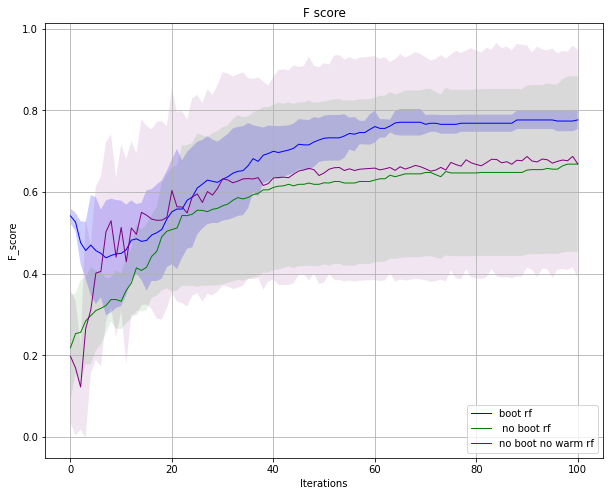

In [92]:
from matplotlib.pyplot import figure
fig, ax = plt.subplots(1)
fig.set_size_inches(10,8)
ax.plot(np.arange(101), f_score_full_rf_mean, lw=1, label='boot rf', color='blue')
#ax.plot(np.arange(101), f_score_full_cmt_mean, lw=1, label='boot committee', color='red')
ax.plot(np.arange(101), f_score_no_boot_rf_mean, lw=1, label=' no boot rf', color='green')
ax.plot(np.arange(101), f_score_rf_noboot_nowarm_mean, lw=1, label='no boot no warm rf', color='purple')
ax.fill_between(np.arange(101), f_score_full_rf_mean + f_score_full_rf_sd, f_score_full_rf_mean-f_score_full_rf_sd
                ,facecolor='blue', alpha=0.2)
#ax.fill_between(np.arange(101), f_score_full_cmt_mean + f_score_full_cmt_sd, f_score_full_cmt_mean-f_score_full_cmt_sd
#                ,facecolor='red', alpha=0.2)
ax.fill_between(np.arange(101), f_score_no_boot_rf_mean + f_score_no_boot_rf_sd, f_score_no_boot_rf_mean-f_score_no_boot_rf_sd
                ,facecolor='green', alpha=0.1)
ax.fill_between(np.arange(101), f_score_rf_noboot_nowarm_mean + f_score_rf_noboot_nowarm_sd, f_score_rf_noboot_nowarm_mean-f_score_rf_noboot_nowarm_sd
                ,facecolor='purple', alpha=0.1)                                
ax.set_title('F score')
ax.legend(loc='lower right')
ax.set_xlabel('Iterations')
ax.set_ylabel('F_score')

ax.grid()

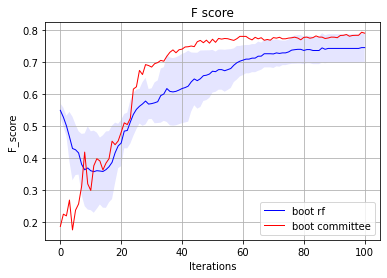

In [42]:
fig, ax = plt.subplots(1)
ax.plot(np.arange(101), f_score_full_rf_mean, lw=1, label='boot rf', color='blue')
ax.plot(np.arange(101), f_score_full_cmt_mean, lw=1, label='boot committee', color='red')
#ax.plot(np.arange(101), f_score_no_boot_rf_mean, lw=1, label=' no boot rf', color='green')
#ax.plot(np.arange(101), f_score_rf_noboot_nowarm_mean, lw=1, label='no boot no warm rf', color='purple')
ax.fill_between(np.arange(101), f_score_full_rf_mean + f_score_full_rf_sd, f_score_full_rf_mean-f_score_full_rf_sd
                ,facecolor='blue', alpha=0.1)
#ax.fill_between(np.arange(101), f_score_full_cmt_mean + f_score_full_cmt_sd, f_score_full_cmt_mean-f_score_full_cmt_sd
#                ,facecolor='blue', alpha=0.2)
#ax.fill_between(np.arange(101), f_score_no_boot_rf_mean + f_score_no_boot_rf_sd, f_score_no_boot_rf_mean-f_score_no_boot_rf_sd
#                ,facecolor='blue', alpha=0.2)
#ax.fill_between(np.arange(101), f_score_rf_noboot_nowarm_mean + f_score_rf_noboot_nowarm_sd, f_score_rf_noboot_nowarm_mean-f_score_rf_noboot_nowarm_sd
#                ,facecolor='purple', alpha=0.1)                                
ax.set_title('F score')
ax.legend(loc='lower right')
ax.set_xlabel('Iterations')
ax.set_ylabel('F_score')
ax.grid()